In [1]:
!pip install tensorflow==2.9.0
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully unin

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2023-03-14 02:37:55--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.218.113, 3.5.6.217, 52.217.172.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.218.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  87.1MB/s    in 2.8s    

2023-03-14 02:37:58 (87.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip /content/train2017.zip

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip /content/val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [4]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataDir='/content/data'
dataType='val'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)
# annFile='{}/annotations/coco.json'.format(dataDir)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

Number of images containing all the  classes: 11


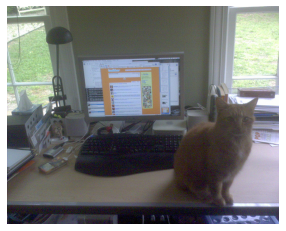

In [8]:

filterClasses = ['laptop', 'tv', 'cell phone']
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# print(catIds)
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
# print(imgIds)
# # imgIds = coco.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}2017/{}'.format(dataDir,'val',img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

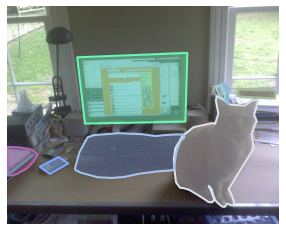

In [9]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [10]:

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is cell phone


In [11]:

#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['laptop', 'tv', 'cell phone']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

ValueError: ignored

pt 2

In [12]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}2017.json'.format(folder, mode)
    # annFile = '{}/annotations/coco.json'.format(folder)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [13]:
folder = '/content/data'
classes = ['laptop', 'tv', 'cell phone']
# classes = None
# classes = ['Leaf', 'Leaf_Diseased', 'Background']
mode = 'val'

images, dataset_size, coco = filterDataset(folder, classes, mode)

print(images)
print(dataset_size)
print(coco)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
[{'license': 3, 'file_name': '000000419653.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000419653.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-24 04:54:48', 'flickr_url': 'http://farm1.staticflickr.com/120/304375762_a1ee10bd0f_z.jpg', 'id': 419653}, {'license': 1, 'file_name': '000000189436.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000189436.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-24 21:53:22', 'flickr_url': 'http://farm7.staticflickr.com/6009/5992565553_3f65c6839f_z.jpg', 'id': 189436}, {'license': 1, 'file_name': '000000445792.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000445792.jpg', 'height': 375, 'width': 500, 'date_captured': '2013-11-21 23:54:19', 'flickr_url': 'http://farm1.staticflickr.com/163/385893071_5d60bf0cd5_z.jpg', 'id': 445792}, {'license': 1, 'file_name': '000000324715.jpg', 'coco_url': 'http://images

In [14]:
import segmentation_models as sm
BACKBONE = 'mobilenetv2'
# print(sm.get_available_backbone_names)
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [15]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # train_img = io.imread(img_folder + '/' + imageObj['file_name'])
    # train_img = preprocess_input(train_img)
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}2017'.format(folder, mode)
    # img_folder = '{}/images'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [16]:
batch_size = 4
input_image_size = (256,256)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

In [17]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

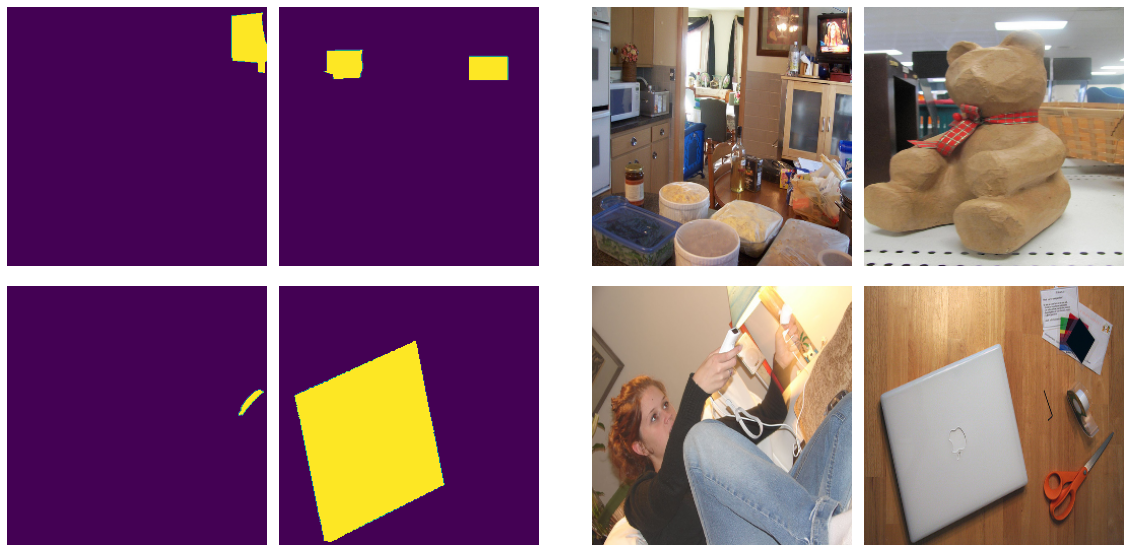

In [18]:
visualizeGenerator(val_gen)

In [19]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

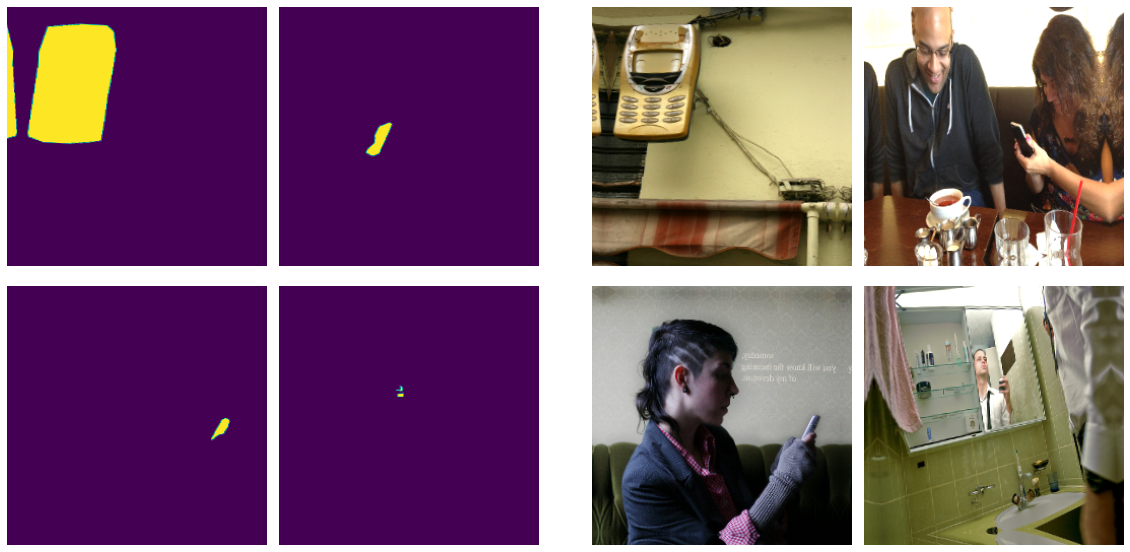

In [20]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

visualizeGenerator(aug_gen)

In [21]:
import tensorflow as tf

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


# print(sample_image.shape)
# model.predict(sample_image[tf.newaxis, ...])

In [22]:
# -> Create filtered train dataset (using filterDataset()) 
train_images, train_size, train_coco = filterDataset(folder, classes=classes, mode='train')
print(train_size)
# -> Create filtered val dataset (using filterDataset()) 
val_images, val_size, val_coco = filterDataset(folder, classes=classes, mode='val')
print(val_size)
# images = np.array(images, dtype=object)
batch_size = 32
input_image_size = (224,224)
mask_type = 'normal'




# -> Create train generator (using dataGeneratorCoco()) 
mode = 'train'
train_gen = dataGeneratorCoco(train_images, classes, train_coco, folder,
                            input_image_size, batch_size, mode, mask_type)
# -> Create train generator (using dataGeneratorCoco()) 
mode = 'val'
val_gen = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, batch_size, mode, mask_type)




n_epochs = 10

steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size


# model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=4, activation='softmax')
# model.compile('Adam', loss=sm.losses.CategoricalFocalLoss() , metrics=[sm.metrics.iou_score])



img, mask = next(val_gen)
sample_image = img[0]
sample_mask = mask[0]
# print(sample_image.shape)
# print(np.unique(sample_mask))
# show_predictions()



loading annotations into memory...
Done (t=26.90s)
creating index...
index created!
10903
loading annotations into memory...
Done (t=3.03s)
creating index...
index created!
503


In [23]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=224, num_classes=4)
# model.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
# Start the training process
# history = model.fit(x = train_gen,
#                 validation_data = val_gen,
#                 steps_per_epoch = steps_per_epoch,
#                 validation_steps = validation_steps,
#                 epochs = n_epochs,
#                 verbose = True,
#                 callbacks=[DisplayCallback()])


# train model
# history = model.fit_generator(
#     train_gen, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=n_epochs, 
#     callbacks=[DisplayCallback()], 
#     validation_steps = validation_steps,
#     validation_data=val_gen
# )

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[DisplayCallback()])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

Epoch 1/25
      3/Unknown - 172s 53s/step - loss: 1.0270 - accuracy: 0.6856